In [40]:
import os, sys
sys.path += [os.path.dirname('../scripts/')]

In [41]:
import pandas as pd
import torch

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [43]:
model_ckpt = 'lang'

In [44]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/' + model_ckpt + '/model')
model = ViTForImageClassification.from_pretrained('../outputs/' + model_ckpt + '/model').to(device)

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [45]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])
valaro_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                  '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                  transform=transform,
                                  mode='valence-arousal')
emotion_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                   '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                   transform=transform,
                                   mode='classification')

In [46]:
from tqdm import tqdm
import numpy as np

def head_outputs_valaro(model, dataset, device):
    features = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            feature = model(img.unsqueeze(0).to(device)).logits
        features.append(feature.cpu())
        labels.append(label)
    features = torch.stack(features).squeeze()
    labels = torch.stack(labels)
    data = np.column_stack((features, labels))
    np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"head_and_valaro.csv"), data, delimiter=',')
    return features, labels

def head_outputs_emotion(model, dataset, device):
    features = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            feature = model(img.unsqueeze(0).to(device)).logits
        features.append(feature.cpu())
        labels.append(label)
    features = torch.stack(features).squeeze()
    labels = torch.stack(labels)
    data = np.column_stack((features, labels))
    np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"head_and_emotion.csv"), data, delimiter=',')
    return features, labels

In [47]:
from typing import Literal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from umap.umap_ import UMAP
from sklearn.manifold import MDS


def plot_tokens_valence(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_umap_head_valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_mds_head_valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=valence,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    color_bar.set_label('valence')
    return fig, None

def plot_tokens_arousal(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_umap_head_valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_mds_head_valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=arousal,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    # color_bar.set_label('valence')
    color_bar.set_label('arousal')
    return fig, None


def plot_tokens_category(tokens, labels, n_neighbors, id2label, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, labels.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_umap_emotion.csv"), data, delimiter=",")
        ys = labels.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, labels.numpy()))
        np.savetxt(os.path.join(f'data/head_align/{model_ckpt}'+"_mds_emotion.csv"), data, delimiter=",")
        ys = labels.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        ys = df[cols[2:]].values
        ys = ys.reshape((ys.shape[0]))
        print(ys)
    data = np.column_stack((zs, ys))
    # np.savetxt(os.path.join(f'data/{model_ckpt}'+"emotion.csv"), data, delimiter=",")
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    ax.set_box_aspect(1)

    label2point = {}
    print('plotting tokens...')
    for x, y in tqdm(zip(zs, ys)):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    # fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.5))
    legend = ax.legend(handles, labels, loc='upper left',
                       bbox_to_anchor=(1.2, 0.5))
    return fig, legend

In [48]:
heads, labels = head_outputs_valaro(model, valaro_dataset, device)
heads.shape, labels.shape

100%|██████████| 4000/4000 [01:22<00:00, 48.70it/s]


(torch.Size([4000, 64]), torch.Size([4000, 2]))

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


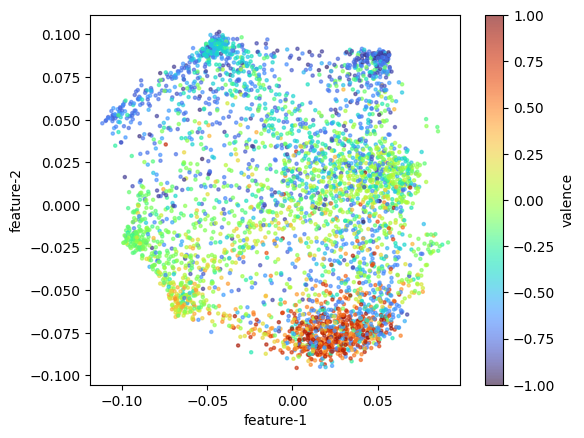

In [49]:
fig, legend = plot_tokens_valence(heads, labels, 20, 0, 'mds', None)

In [50]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_valence'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_valence'+'.png'), bbox_inches='tight')

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


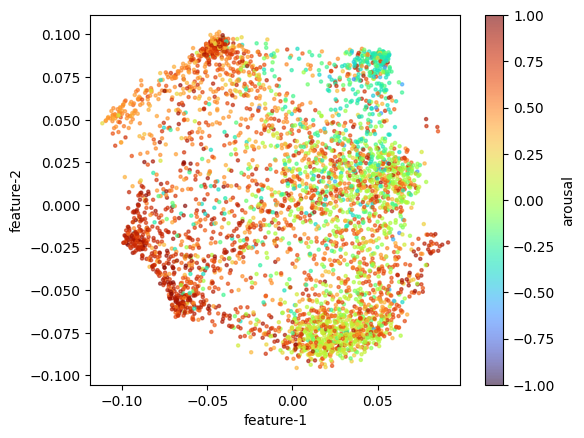

In [51]:
fig, legend = plot_tokens_arousal(heads, labels, 20, 0, 'mds', None)

In [52]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_arousal'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_arousal'+'.png'), bbox_inches='tight')

100%|██████████| 4000/4000 [01:54<00:00, 35.05it/s]
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_2432872/2680380471.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


plotting tokens...


4000it [00:23, 173.70it/s]


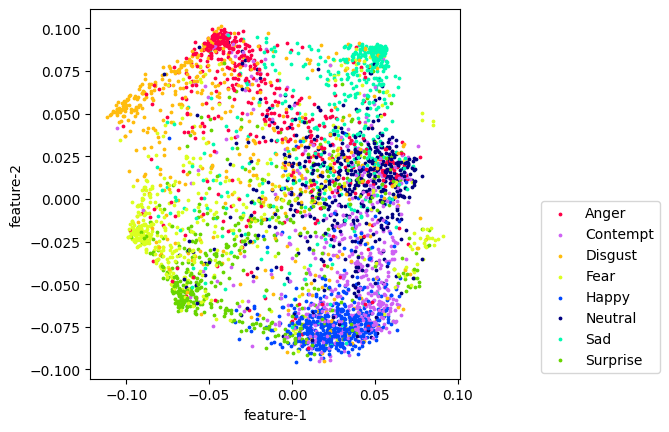

In [53]:
from utils import exclude_id

id2label, label2id = exclude_id([8,9,10])

heads, labels = head_outputs_emotion(model, emotion_dataset, device)
fig, legend = plot_tokens_category(heads, labels, 20, id2label, 0, 'mds', None)

In [54]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_emotion'+'.svg'), bbox_inches='tight', bbox_extra_artists=[
                    legend])
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'head_emotion'+'.png'), bbox_inches='tight', bbox_extra_artists=[
                    legend])